# Assignment 1
\- Yash Gupta (190997)

In [4]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from copy import deepcopy

In [2]:
from brian2 import *

## Integrate-and-fire neuron model

This is one of the simplest models of neuron behavior. It omits all the intricacies of what goes on electrochemically inside the neuron's body, and simply attempts to capture the basic 'accumulate till a threshold and then fire and let go of all the accumulation' aspect of a neuron's activity 

$$\frac{dv}{dt} = \frac{(v_0 - v)}{\tau},$$

where $v$ is the membrane voltage of the neuron, and $\tau$ is a timescale factor.

In [3]:
v0 = 1
tau = 10*ms
eqs = '''
dv/dt = (v0-v)/tau : 1
'''

In [4]:
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')
M = StateMonitor(G, 'v', record=True)
spikemon = SpikeMonitor(G)

Text(0, 0.5, 'v')

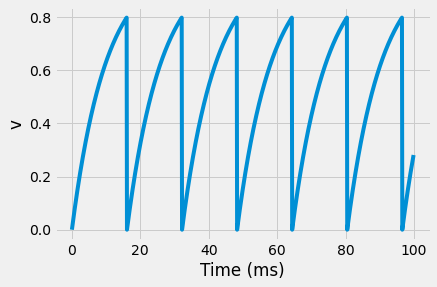

In [5]:
run(100*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')

## Hopfield network model

In this simplified Hopfied model, each neuron can only take values +1 or -1. The network stores pixel patterns, and attempts to retrieve them given some cue in the form of a part of the original pattern used to set an initial state $S_i(t=0)$ for every neuron in the network. The network activation of all the neurons evolves as follows

$$S_i(t+1) = sgn\left(\sum_j{w_{ij} S_j(t)}\right), $$

where the weight of every synaptic connection is calculated as,

$$w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu}, $$

where in turn, $N$ is the number of neurons, and $p_i^\mu$ is the state of the $i^{th}$ neuron for encoding pattern $\mu$.

The code below is taken from this [link](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hopfield-network.html). Follow the accompanying exercises to be better prepared for your assignment. Remember to install all needed libraries before trying to run it. 

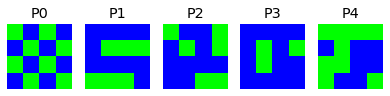

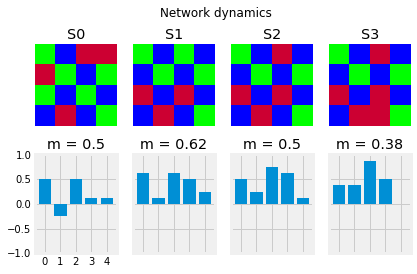

In [118]:
%matplotlib inline
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools

pattern_size = 4

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]

# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=4, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)
# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
#plot_tools.plot_overlap_matrix(overlap_matrix)

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

# create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=4)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=3)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)
# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")


## Our own Hopfield network model

## Assignment 1

Q1. Can you write you own Hopfield network model that works more or less like the one simulated above? (20 points)

Q2. Run the model with different parameters to figure out how the model's capacity to retrieve the correct pattern in response to a cue deteriorates as a function of 
(a) the informativeness of the cue
(b) the number of other patterns stored in the network
(c) the size of the network

Present your answers with plots and/or math. (20 points)

Q3. Can you write a function that converts MNIST digit [data](https://gitlab.com/datapythonista/mnist) to the sort of patterns used in this simulation? (20 points)

Q4. Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with [classical](https://github.com/ksopyla/svm_mnist_digit_classification) and [deep](https://github.com/hwalsuklee/tensorflow-mnist-cnn) supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier (40 points) 

### Q1. 
Can you write you own Hopfield network model that works more or less like the one simulated above? (20 points)

Let's create the functions for the Hopfield network

In [21]:
def get_patterns(pattern_size, pattern_num):
    """
    Returns a list of pattern_num random patterns of size (pattern_size, pattern_size)
    """
    plist = []
    for i in range(pattern_num):
        pattern = np.empty((pattern_size, pattern_size))
        for j in range(pattern_size):
            for k in range(pattern_size):
                pattern[j][k] = random.choice([-1, 1])
        plist.append(pattern)
    return plist

def perturb_pattern(pattern, perturb_num):
    """
    Returns a noisy version of pattern with perturb_num flips
    """
    pattern_size = len(pattern)
    idx = random.sample(range(pattern_size ** 2), perturb_num)
    for i in range(perturb_num):
        j = idx[i] // pattern_size
        k = idx[i] % pattern_size
        pattern[j][k] *= -1
    return pattern

def calculate_weights(plist, pattern_size):
    """
    Learns the patterns in plist and returns the weights
    """
    num_neurons = pattern_size ** 2
    wghts = np.empty((num_neurons, num_neurons))
    for i in range(num_neurons):
        for j in range(num_neurons):
            sum = 0
            for k in range(len(plist)):
                sum += plist[k][i // pattern_size][i % pattern_size] * plist[k][j // pattern_size][j % pattern_size]
            wghts[i][j] = sum / num_neurons
    return wghts

def network_evolution(S, wghts):
    """
    Calculates and returns the next state using the wghts
    """
    num_neurons = len(S) ** 2
    S_new = deepcopy(S)
    for i in range(num_neurons):
        sum = 0
        for j in range(num_neurons):
            sum += wghts[i][j] * S[j // len(S)][j % len(S)]
        S_new[i // len(S)][i % len(S)] = np.sign(sum) if np.sign(sum) != 0 else 1
    return S_new

In [22]:
def create_network(pattern_size, pattern_num, perturb_num, evolution_num):
    plist = get_patterns(pattern_size, pattern_num)

    cue = deepcopy(plist)

    S = perturb_pattern(cue[0], perturb_num)
    wghts = calculate_weights(plist, pattern_size)

    state_list = [S]

    S_cur = deepcopy(S)
    for i in range(evolution_num):
        S_cur = network_evolution(S_cur, wghts)
        state_list.append(S_cur)
    
    return plist, S, state_list

def plot_network(plist, cue, state_list):
    print('The patterns:')
    plot_tools.plot_pattern_list(plist)

    print('The noisy pattern:')
    plot_tools.plot_pattern(cue)

    print('Evolution of the network:')
    plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle="Network dynamics")

Now, let's build the Hopfield Network

The patterns:


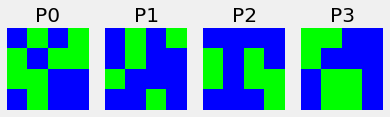

The noisy pattern:


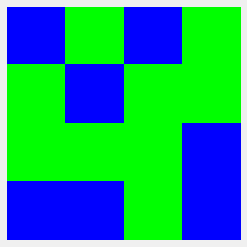

Evolution of the network:



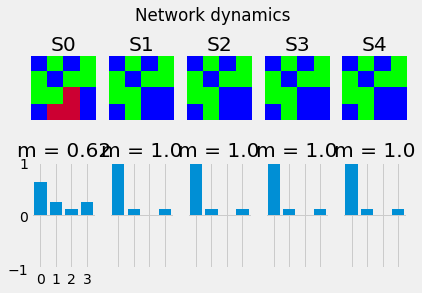

In [23]:
plist, cue, state_list = create_network(pattern_size=4, pattern_num=4, perturb_num=3, evolution_num=4)
plot_network(plist, cue, state_list)

### Q2.
Run the model with different parameters to figure out how the model's capacity to retrieve the correct pattern in response to a cue deteriorates as a function of  
- the informativeness of the cue  
- the number of other patterns stored in the network  
- the size of the network

#### (a) the informativeness of the cue  
It can be varied by changing the number of pertubations in the initial cue. The more is the number of pertubations/flips, the lower is the informativeness of the cue. 

Let's find the model's capacity to retrieve the correct pattern by varying the number of perturbations from 1 to 100

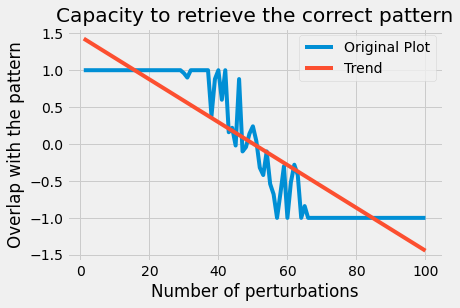

In [33]:
overlaps = []

perturb_nums = range(1, 101)
for i in perturb_nums:
  plist, cue, state_list = create_network(pattern_size=10, pattern_num=6, perturb_num=i, evolution_num = 3)
  overlap = pattern_tools.compute_overlap(state_list[-1], plist[0])
  overlaps.append(overlap)

plt.title("Capacity to retrieve the correct pattern")
plt.xlabel('Number of perturbations')
plt.ylabel('Overlap with the pattern')
plt.plot(perturb_nums, overlaps, label = 'Original Plot')

m, b = np.polyfit(perturb_nums, overlaps, 1)
trend = []
for perturb_num in perturb_nums:
  trend.append(m * perturb_num + b)
plt.plot(perturb_nums, trend, label = 'Trend')
plt.legend()

plt.show()  

So, as we increase the number of perturbations, the model's capacity to retrieve the original state deteriorates. Also, for small number of perturbations, It can reach the original state irrespective of the number of perturbations. 

#### (b) the number of other patterns stored in the network

Let's vary the number of patterns from 1 to 100

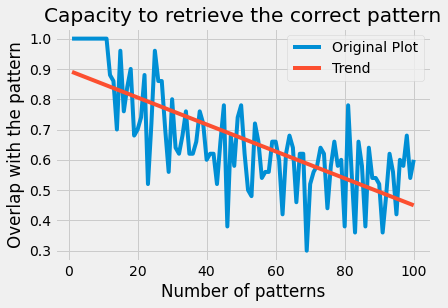

In [34]:
overlaps = []

pattern_nums = range(1, 101)
for i in pattern_nums:
  plist, cue, state_list = create_network(pattern_size=10, pattern_num=i, perturb_num=25, evolution_num = 3)
  overlap = pattern_tools.compute_overlap(state_list[-1], plist[0])
  overlaps.append(overlap)

plt.title("Capacity to retrieve the correct pattern")
plt.xlabel('Number of patterns')
plt.ylabel('Overlap with the pattern')
plt.plot(pattern_nums, overlaps, label = 'Original Plot')

m, b = np.polyfit(pattern_nums, overlaps, 1)
trend = []
for pattern_num in pattern_nums:
  trend.append(m * pattern_num + b)
plt.plot(pattern_nums, trend, label = 'Trend')
plt.legend()

plt.show()  

So, as we increase the number of patterns, the model's capacity to retrieve the original state deteriorates. 

#### (c) the size of the network
Increasing the size of the network means increasing the size of the patterns. 

Let's vary the size of patterns from 3 to 10

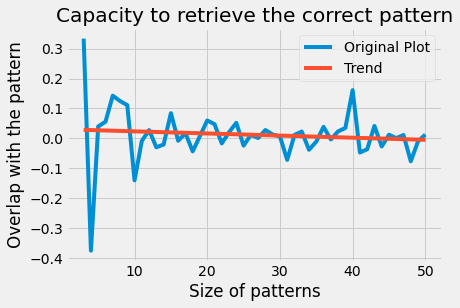

In [41]:
overlaps = []

pattern_sizes = range(3, 51)
for i in pattern_sizes:
  perturb_num = int(0.5 * (i ** 2))
  plist, cue, state_list = create_network(pattern_size=i, pattern_num=5, perturb_num=perturb_num, evolution_num = 3)
  overlap = pattern_tools.compute_overlap(state_list[-1], plist[0])
  overlaps.append(overlap)

plt.title("Capacity to retrieve the correct pattern")
plt.xlabel('Size of patterns')
plt.ylabel('Overlap with the pattern')
plt.plot(pattern_sizes, overlaps, label = 'Original Plot')

m, b = np.polyfit(pattern_sizes, overlaps, 1)
trend = []
for pattern_size in pattern_sizes:
  trend.append(m * pattern_size + b)
plt.plot(pattern_sizes, trend, label = 'Trend')
plt.legend()

plt.show()  

So, as we increase the size of the network, the model's capacity to retrieve the original state does not change much

### Q3.
Can you write a function that converts MNIST digit [data](https://gitlab.com/datapythonista/mnist) to the sort of patterns used in this simulation?

In [53]:
from tensorflow.keras.datasets import mnist

Getting the MNIST data -

In [54]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

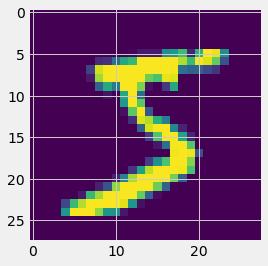

In [76]:
plt.imshow(X_train[0])

In [56]:
print(X_train.shape)

(60000, 28, 28)


In [80]:
print(X_test.shape)

(10000, 28, 28)


Now, let's preprocess the dataset

In [127]:
def shrink(X):
    X_new = []
    for i in range(X.shape[0]):
        img = []
        for j in range(X.shape[1] // 2):
            row = []
            for k in range(X.shape[2] // 2):
                val = max(X[i][2 * j][2 * k], X[i][2 * j][2 * k + 1], X[i][2 * j + 1][2 * k], X[i][2 * j + 1][2 * k + 1])
                row.append(val)
            img.append(row)
        X_new.append(img)
    return np.array(X_new)

def to_binary(X):
    X_new = np.empty((X.shape[0], X.shape[1], X.shape[2]))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            for k in range(X.shape[2]):
                X_new[i][j][k] = 1 if X[i][j][k] > 127 else -1
    return X_new
    

def crop(X):
    new_dim = X.shape[1] - 4
    X_new = np.empty((X.shape[0], new_dim, new_dim))
    for i in range(X.shape[0]):
        X_new[i] = X[i, 2:-2, 2:-2]
    return X_new

def preprocess(X):
    X_new = shrink(X)
    X_new = to_binary(X_new)
    X_new = crop(X_new)
    return X_new

In [128]:
X_train_new = preprocess(X_train)
X_test_new = preprocess(X_test)

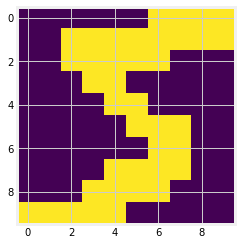

In [129]:
plt.imshow(X_train_new[0])

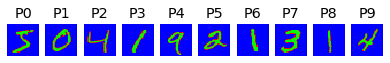

In [130]:
plot_tools.plot_pattern_list(X_train[:10])

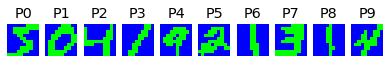

In [131]:
plot_tools.plot_pattern_list(X_train_new[:10])

### Q4.
Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with [classical](https://github.com/ksopyla/svm_mnist_digit_classification) and [deep](https://github.com/hwalsuklee/tensorflow-mnist-cnn) supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier

In [ ]:
def create_network(pattern_size, pattern_num, perturb_num, evolution_num):
    plist = get_patterns(pattern_size, pattern_num)

    cue = deepcopy(plist)

    S = perturb_pattern(cue[0], perturb_num)
    wghts = calculate_weights(plist, pattern_size)

    state_list = [S]

    S_cur = deepcopy(S)
    for i in range(evolution_num):
        S_cur = network_evolution(S_cur, wghts)
        state_list.append(S_cur)
    
    return plist, S, state_list